# KCP Dataset PDF Cover Page Snapshot

In [1]:
%load_ext autotime

In [2]:
from wb_nlp import dir_manager

time: 135 ms


In [3]:
!/home/wb536061/anaconda3/envs/wb_nlp/bin/pip install pdf2image > /dev/null

time: 3.91 s


In [4]:
import requests
import json
import os
import time
import glob
from pathlib import Path
import pandas as pd
import re
from joblib import Parallel, delayed
import pdf2image
import PIL


time: 1.84 s


In [5]:
class DocumentCover:
    def __init__(self, doc_id, cover_dir, pdf_path=None, pdf_url=None, fixed_width=200, fixed_height=None):
        self.doc_id = doc_id
        self.pdf_path = pdf_path
        self.pdf_url = pdf_url
        self.cover_dir = cover_dir
        self.fixed_width = fixed_width
        self.fixed_height = fixed_height

        # self.fname = os.path.join(self.cover_dir, f'{self.doc_id}.png')
        self.fname = self.cover_dir / f'{self.doc_id}.png'

        self.orig_cover = None
        self.cover = None
        self.resized = None

    def get_content_from_url(self):
        self.resized = False
        res = requests.get(self.pdf_url)

        try:
            pages = pdf2image.convert_from_bytes(res.content, size=(self.fixed_width, self.fixed_height), single_file=True)
            self.resized = True
        except:
            pages = pdf2image.convert_from_bytes(res.content)
            
        self.orig_cover = pages[0]

    def get_content_from_file(self):
        self.resized = False
        with open(self.pdf_path, "rb") as open_file:
            content = open_file.read()
            try:
                pages = pdf2image.convert_from_bytes(content, size=(self.fixed_width, self.fixed_height), single_file=True)
                self.resized = True
            except:
                pages = pdf2image.convert_from_bytes(content)

        self.orig_cover = pages[0]

    def standardize_size(self):
        # Not useful if `size` is set in pdf2image.convert_from_bytes
        c = self.orig_cover

        if c is None:
            if self.pdf_path:
                self.get_content_from_file()
            elif self.pdf_url:
                self.get_content_from_url()
            c = self.orig_cover
            assert(c)

        if not self.resized:
            width = self.fixed_width
            w0, h0 = c.size
            c = c.resize((width, int(h0 * width / w0)), resample=PIL.Image.BICUBIC)

        self.cover = c

    def save(self):
        if not os.path.isfile(self.fname):        
            cover = self.cover

            if cover is None:
                self.standardize_size()
                cover = self.cover

            cover.save(self.fname)

        return self.doc_id

    def cleanup(self):
        del(self.orig_cover)
        del(self.cover)

        self.orig_cover = None
        self.cover = None

time: 1.12 ms


In [6]:
corpus_path = Path(dir_manager.get_data_dir("corpus").replace("/home/", "/data/"))
CORPUS_DIRS = list(corpus_path.glob("*/PDF_ORIG"))

time: 1.36 ms


In [7]:
def prepare_meta(corpus_dir):
    data = []
    corpus_id = corpus_dir.parent.name.lower()

    for pdf in corpus_dir.glob("*.pdf"):
        metadata = {}

        if pdf.stem.startswith(f"{corpus_id}_"):
            doc_id = pdf.stem
        else:
            doc_id = f"{corpus_id}_{pdf.stem}"

        metadata["id"] = doc_id
        metadata["pdf_path"] = pdf.resolve()
        metadata["cover_dir"] = (corpus_dir.parent / "COVER").resolve()
        metadata["corpus_id"] = corpus_id

        data.append(metadata)

    return data

time: 423 µs


In [8]:
def parallel_process(row):
    ret = dict(status='ok', doc_id=row['id'], corpus_id=row["corpus_id"], pdf_path=str(row["pdf_path"]))
    try:
        dc = DocumentCover(doc_id=row['id'], cover_dir=row["cover_dir"], pdf_path=row["pdf_path"])
        r = dc.save()
        dc.cleanup()
    except Exception as e:
        ret['status'] = e.__str__()

    return ret

time: 411 µs


In [9]:
dataset = []
for corpus_dir in CORPUS_DIRS:
#     if corpus_dir.parent.name == "IADB":
#         continue
    COVER_DIR = corpus_dir.parent / "COVER"
    if not COVER_DIR.exists():
        COVER_DIR.mkdir(parents=True)

    dataset.extend(prepare_meta(corpus_dir))
len(dataset)

370588

time: 42 s


{'id': 'wfp_eae9b73830c536c966d9ce33f842bfa82660173b', 'pdf_path': PosixPath('/data/wb536061/wb_nlp/data/corpus/WFP/PDF_ORIG/eae9b73830c536c966d9ce33f842bfa82660173b.pdf'), 'cover_dir': PosixPath('/data/wb536061/wb_nlp/data/corpus/WFP/COVER'), 'corpus_id': 'wfp'}


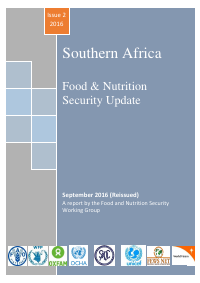

time: 610 ms


In [10]:
# Test
row = dataset[75000]
# row = dataset[0]
print(row)
dc = DocumentCover(doc_id=row['id'], cover_dir=row["cover_dir"], pdf_path=row['pdf_path'])
dc.standardize_size()
dc.cover

In [11]:
NUM_JOBS = 70

pres = Parallel(n_jobs=NUM_JOBS)(delayed(parallel_process)(row) for row in dataset)

time: 22min 57s


# Review rate of unprocessed files, if any

In [12]:
pres_df = pd.DataFrame(pres)
pres_df.head()

,status,doc_id,corpus_id,pdf_path
0,ok,adb_002c7aaec1491e3138ac2223ca65f17733ea42a0,adb,/data/wb536061/wb_nlp/data/corpus/ADB/PDF_ORIG...
1,ok,adb_00007abd8c05787dba667063e1490f029167c809,adb,/data/wb536061/wb_nlp/data/corpus/ADB/PDF_ORIG...
2,ok,adb_002f5758d218224edf1a8b8848a05720ce2bc306,adb,/data/wb536061/wb_nlp/data/corpus/ADB/PDF_ORIG...
3,ok,adb_0000dbf02cf5d1daa980284af565858ffb857912,adb,/data/wb536061/wb_nlp/data/corpus/ADB/PDF_ORIG...
4,ok,adb_002fe99dbbfc07d5967f99599000e55c25b0c48f,adb,/data/wb536061/wb_nlp/data/corpus/ADB/PDF_ORIG...


time: 852 ms


In [13]:
100 * (pres_df[pres_df["status"] != "ok"]["corpus_id"].value_counts() / pres_df["corpus_id"].value_counts()).dropna().sort_values(ascending=False)

iadb     99.847561
oecd     77.714286
unpd      1.284797
wb        0.600964
unhcr     0.114723
wfp       0.072701
adb       0.001827
Name: corpus_id, dtype: float64

time: 185 ms


In [14]:
pres_df[pres_df["status"] != "ok"]["corpus_id"].value_counts()

iadb     8515
wb       1775
oecd      272
unpd        6
unhcr       3
wfp         2
adb         1
Name: corpus_id, dtype: int64

time: 63.6 ms


In [15]:
pres_df["corpus_id"].value_counts()

wb         295359
adb         54743
iadb         8528
eclac        2962
wfp          2751
unhcr        2615
afdb          952
unescwa       693
uneca         536
unpd          467
escap         438
oecd          350
fao            99
epdc           57
unodc          28
who             9
ilo             1
Name: corpus_id, dtype: int64

time: 83.6 ms


In [ ]:
# !ls -l /R/NLP/CORPUS/WB/cover | wc -l

In [16]:
!df -h

Filesystem                          Size  Used Avail Use% Mounted on
devtmpfs                            126G     0  126G   0% /dev
tmpfs                               126G   56K  126G   1% /dev/shm
tmpfs                               126G  1.9G  125G   2% /run
tmpfs                               126G     0  126G   0% /sys/fs/cgroup
/dev/mapper/rhel_w1lxbdatad02-root  669G  312G  358G  47% /
/dev/sda1                            20G  253M   20G   2% /boot
/dev/sdd1                           5.4T  4.5T  911G  84% /data
tmpfs                               126G   87M  126G   1% /tmp
/dev/mapper/rhel_w1lxbdatad02-var   300G  262G   39G  88% /var
tmpfs                                26G     0   26G   0% /run/user/536061
tmpfs                                26G     0   26G   0% /run/user/0
time: 795 ms


In [17]:
!df -h

Filesystem                          Size  Used Avail Use% Mounted on
devtmpfs                            126G     0  126G   0% /dev
tmpfs                               126G   56K  126G   1% /dev/shm
tmpfs                               126G  1.9G  125G   2% /run
tmpfs                               126G     0  126G   0% /sys/fs/cgroup
/dev/mapper/rhel_w1lxbdatad02-root  669G  312G  358G  47% /
/dev/sda1                            20G  253M   20G   2% /boot
/dev/sdd1                           5.4T  4.5T  911G  84% /data
tmpfs                               126G   87M  126G   1% /tmp
/dev/mapper/rhel_w1lxbdatad02-var   300G  262G   39G  88% /var
tmpfs                                26G     0   26G   0% /run/user/536061
tmpfs                                26G     0   26G   0% /run/user/0
time: 251 ms


In [ ]:
# You can pass it as a build arg. Your Dockerfile can be static:

# FROM ubuntu:xenial-20170214
# ARG UNAME=testuser
# ARG UID=1000
# ARG GID=1000
# RUN groupadd -g $GID -o $UNAME
# RUN useradd -m -u $UID -g $GID -o -s /bin/bash $UNAME
# USER $UNAME
# CMD /bin/bash
# Then you'd pass the options on your build command:

# docker build --build-arg UID=$(id -u) --build-arg GID=$(id -g) \
#   -f bb.dockerfile -t testimg .

In [28]:
from pathlib import Path
# corpus_dir = Path('/data/wb536061/wb_nlp/data/corpus')
corpus_dir = Path('/workspace/data/corpus')

base_dirs_ext = {
    "TXT_ORIG": ".txt",
    "PDF_ORIG": ".pdf",
    "NON_EN_TXT_ORIG": ".txt",
    "EN_TXT_ORIG": ".txt",
    "COVER": ".png",  # Naming alread fixed.  
}

for base_dir, ext in base_dirs_ext.items():
    print(base_dir)
    for path in corpus_dir.glob(f"*/{base_dir}/*{ext}"):
        if path.is_file():
            corpus_id = path.parent.parent.name.lower()
            if path.name.startswith(f"{corpus_id}_"):
                continue
            new_name = path.parent / f"{corpus_id}_{path.name}"
            # print(new_name)
            path.rename(new_name)

time: 210 µs


In [31]:
from pathlib import Path
# corpus_dir = Path('/data/wb536061/wb_nlp/data/corpus')
corpus_dir = Path('/workspace/data/corpus')

base_dirs_ext = {
    "TXT_ORIG": ".txt",
    "PDF_ORIG": ".pdf",
    "NON_EN_TXT_ORIG": ".txt",
    # "EN_TXT_ORIG": ".txt",
    "COVER": ".png",  # Naming alread fixed.  
}

for path in corpus_dir.glob(f"WB/COVER/*.png"):
    if path.is_file():
        corpus_id = path.parent.parent.name.lower()
        if path.name.startswith(f"{corpus_id}_{corpus_id}_"):
            new_name = path.parent / "_".join(path.name.split("_")[1:])
#             print(new_name)
            path.rename(new_name)
#     break

/data/wb536061/wb_nlp/data/corpus/WB/COVER/wb_D32658475.png
time: 213 ms


In [30]:
path

PosixPath('/data/wb536061/wb_nlp/data/corpus/ADB/TXT_ORIG/002c7aaec1491e3138ac2223ca65f17733ea42a0.txt')

time: 1.49 ms
